In [188]:
import numpy as np
from Bio import SeqIO
from collections import defaultdict
from copy import deepcopy
import networkx as nx 
import matplotlib.pyplot as plt 
import sys
from pyvis.network import Network
from netgraph import MultiGraph # pip install https://github.com/paulbrodersen/netgraph/archive/dev.zip

sys.setrecursionlimit(10000000)

## Генерация тестовых данных

In [16]:

np.random.seed(0)

nucleotides = ['A', 'T', 'G', 'C']

sequence_string = ''.join(np.random.choice(nucleotides, 1000).tolist())
reads = ''

for i in range(1, 1001):
    read_len = 150
    read_start = np.random.default_rng().integers(0, 1000 - read_len)
    read_str = sequence_string[read_start:read_start+read_len]
    reads += f'>READ_SEQ_{i}\n{read_str}\n'

with open(f"reads.fasta", "w") as file:
    file.write(reads)

with open("sequense.fasta", "w") as file:
    file.write('>MAIN_SEQ_0\n')
    file.write(sequence_string)

## Построение графа Де Брюина
По заданному набору ридов в формате FASTQ и параметру k, который соответствует длине k-меров, построить граф Де Брюина, некоторый путь в котором соответствовал бы возможной подстроке в исходном геноме. Не забывайте про запоминание покрытия каждого k-мера, а так же про сами подстроки, которые соответствуют каждому ребру. В остальном граф полностью соответствует тому, что был описан в лекции.

In [189]:
class Node():
    def __init__(self):
        self.in_degree = 0
        self.out_degree = 0

class Edge():
    def __init__(self, prev_node, next_node, string, coverage=1):
        self.prev_node = prev_node
        self.next_node = next_node
        self.string = string
        self.coverage = coverage

class DBGraph():
    def __init__(self, reads, k):
        self.reads = reads
        self.k = k
        self.used_edges = set()
        self.used_nodes = set()
        self.nodes = {}
        self.edges = {}
        self.connections = defaultdict(list)
        self.kmers = []
        self.compacted = False
        self.deleted_tails = False
        self.string = None

    def gen_kmers(self):
        for read in self.reads:
            self.kmers.extend([read[i:self.k+i] for i in range(0, len(read)-self.k+1)])

    def create_graph(self):
        for kmer in self.kmers:
            prev_node_str = kmer[:-1]
            next_node_str = kmer[1:]
            if prev_node_str not in self.used_nodes:
                self.nodes[prev_node_str] = Node()
                self.used_nodes.add(prev_node_str)
            if next_node_str not in self.used_nodes:
                self.nodes[next_node_str] = Node()
                self.used_nodes.add(next_node_str)
            if kmer in self.used_edges:
                self.edges[kmer].coverage += 1
            else:
                self.used_edges.add(kmer)
                self.edges[kmer] = Edge(prev_node_str, next_node_str, kmer)
                self.connections[prev_node_str].append(self.edges[kmer])
                self.nodes[prev_node_str].out_degree += 1
                self.nodes[next_node_str].in_degree += 1

    def _find_linear_path(self, edge):
        path = [edge]
        while self.nodes[edge.next_node].out_degree == 1 and self.nodes[edge.next_node].in_degree == 1:
            edge = self.connections[edge.next_node][0]
            path.append(edge)
        return path

    def compact(self):  # Task 2
        for node in [node for node in self.nodes if self.nodes[node].out_degree > 1 or self.nodes[node].in_degree != 1]:
            for start_edge_idx in range(len(self.connections[node])):
                start_edge = self.connections[node][start_edge_idx]
                linear_path = self._find_linear_path(start_edge)
                if len(linear_path) > 1:
                    new_edge_string = start_edge.string
                    new_edge = start_edge
                    for edge in linear_path[1:]:
                        new_edge_string += edge.string[-1]
                        new_edge_coverage = round((len(new_edge.string)*new_edge.coverage + len(edge.string)*edge.coverage)/(len(new_edge.string) + len(edge.string)))
                        new_edge = Edge(node, edge.next_node, new_edge_string, new_edge_coverage)
                        del self.connections[edge.prev_node]
                        del self.nodes[edge.prev_node]
                    self.connections[node][start_edge_idx] = new_edge
        for node in list(self.connections):
            if not self.connections[node]:
                del self.connections[node]

    def _check_tails(self):
        for node in self.nodes:
            if self.nodes[node].out_degree == 0:
                return True
        return False

    def delete_tails(self):  # Task 3
        if not self._check_tails():
            print('This graph does not have tails!')
            return
        self.tails = {}
        for node in [node for node in self.nodes if self.nodes[node].out_degree > 1]:
            for start_edge_idx in range(len(self.connections[node])):
                start_edge = self.connections[node][start_edge_idx]
                linear_path = self._find_linear_path(start_edge)
                if self.nodes[linear_path[-1].next_node].out_degree == 0:
                    tail_coverage = 0
                    tail_len = 0
                    for edge in linear_path:
                        tail_len += 1
                        tail_coverage += edge.coverage
                    self.tails[start_edge] = tail_len*tail_coverage
        if len(self.tails) > 1:
            tails_min_scores = set(np.sort(list(self.tails.values()))[:round(len(self.tails)*0.3)])
            for tail in self.tails:
                if self.tails[tail] in tails_min_scores:
                    start_edge = tail
                    start_node = start_edge.prev_node
                    self.connections[start_node].remove(start_edge)
                    self.nodes[start_node].out_degree -= 1
                    if self.nodes[start_edge.next_node].out_degree:
                        start_edge = self.connections[start_edge.next_node][0]
                        while True:
                            del self.connections[start_edge.prev_node]
                            del self.nodes[start_edge.prev_node]
                            if not self.nodes[start_edge.next_node].out_degree:
                                break
                            start_edge = self.connections[start_edge.next_node][0]
                    del self.nodes[start_edge.next_node]

    def delete_bubbles(self):  # Task 4
        for node in [node for node in self.nodes if self.nodes[node].out_degree == 2]:
            path_1_edge, path_2_edge = self.connections[node]
            path_1 = self._find_linear_path(path_1_edge)
            path_2 = self._find_linear_path(path_2_edge)
            if path_1[-1].next_node == path_2[-1].next_node:
                if len(path_1) <= 2*self.k:
                    self.connections[node].remove(path_1[0])
                    for edge in path_1[:-1]:
                        del self.connections[edge.next_node]
                        del self.nodes[edge.next_node]
                    self.nodes[node].out_degree -= 1
                    self.nodes[path_1[-1].next_node].in_degree -= 1
                elif len(path_2) <= 2*self.k:
                    self.connections[node].remove(path_1[0])
                    for edge in path_2[:-1]:
                        del self.connections[edge.next_node]
                        del self.nodes[edge.next_node]
                    self.nodes[node].out_degree -= 1
                    self.nodes[path_1[-1].next_node].in_degree -= 1

    def _print_connections(self):
        print(self.connections)

    def _print_nodes(self):
        for node in self.nodes:
            print(node)
            print(self.nodes[node].in_degree)
            print(self.nodes[node].out_degree)

    def _find_euler_path(self, v):
        for edge in self.connections_temp[v]:
            if edge.coverage:
                edge.coverage -= 1
                self.string += edge.string[(self.k-1):]
                self._find_euler_path(edge.next_node)

    def assemble(self, multiple_start=False):
        in_degrees = [self.nodes[i].in_degree for i in self.connections.keys()]
        nodes_min_in_degrees = [list(self.connections.keys())[i] for i in range(len(in_degrees)) if in_degrees[i] == min(in_degrees)]
        if multiple_start:
            for start in nodes_min_in_degrees:
                self.connections_temp = deepcopy(self.connections)
                self.string = self.connections[start][0].string[:(self.k-1)]
                self._find_euler_path(start)
        else:
            start = nodes_min_in_degrees[0]
            self.connections_temp = deepcopy(self.connections)
            self.string = self.connections[start][0].string[:(self.k-1)]
            self._find_euler_path(start)
        return self.string
    
    def visualize(self, interactive=False, show_edges=False, layout=nx.kamada_kawai_layout):
        edge_labels = {}
        G = nx.MultiDiGraph() 
        for node in self.connections:
            for edge in self.connections[node]:
                edge_labels[(edge.prev_node, edge.next_node)] = edge.string
                G.add_edge(edge.prev_node, edge.next_node)
        pos = layout(G)
        if interactive:
            nt = Network('2000px', '2000px', directed=True)
            nt.from_nx(G)
            nt.show('test.html', notebook=False)
        else:
            plt.figure(figsize=(20,15))
            nx.draw_networkx_nodes(G, pos, node_color = '#3DC2EC', node_size = 200, alpha = 1)
            nx.draw_networkx_edges(G, pos)
            nx.draw_networkx_labels(G, pos, font_size=9)
            if show_edges:
                nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)
            plt.show()


    def get_statistics(self):  # Task 5
        edge_coverage = []
        node_degrees = []
        n_edges = 0
        n_nodes = len(self.nodes)
        for node in self.connections:
            node_degrees.append(self.nodes[node].in_degree + self.nodes[node].out_degree)
            for edge in self.connections[node]:
                edge_coverage.append(edge.coverage)
                n_edges += 1
        print('Number edges:', n_edges)
        print('Number nodes:', n_nodes)
        figure, axis = plt.subplots(1, 2, figsize=(25, 5))
        counts_edge, bins_edge = np.histogram(edge_coverage)
        axis[0].hist(bins_edge[:-1], 10, weights=counts_edge)
        axis[0].set_title('Edge coverage')
        counts_node, bins_node = np.histogram(node_degrees)
        axis[1].hist(bins_node[:-1], 10, weights=counts_node)
        axis[1].set_title('Node degrees')
        plt.show()
    
    def get_shared_motif(self, true_seq):
        if not self.string:
            print('Do assemble first!')
            return
        s_seq = self.string if len(self.string) <= len(true_seq) else true_seq
        l_seq = self.string if len(self.string) > len(true_seq) else true_seq
        motif = set()
        for i in range(len(s_seq)):
            for j in range(i+1, len(s_seq)+1):
                motif.add(s_seq[i:j])
        update_motif = list(motif)
        for m in update_motif:
            if m not in l_seq:
                motif.remove(m)
        motif = list(motif)
        longest_motif = motif[np.argmax([len(i) for i in motif])]
        print('Longest shared motif is:\n', longest_motif, sep='', end='\n\n\n')


### Тест на построение графа и его сжатие

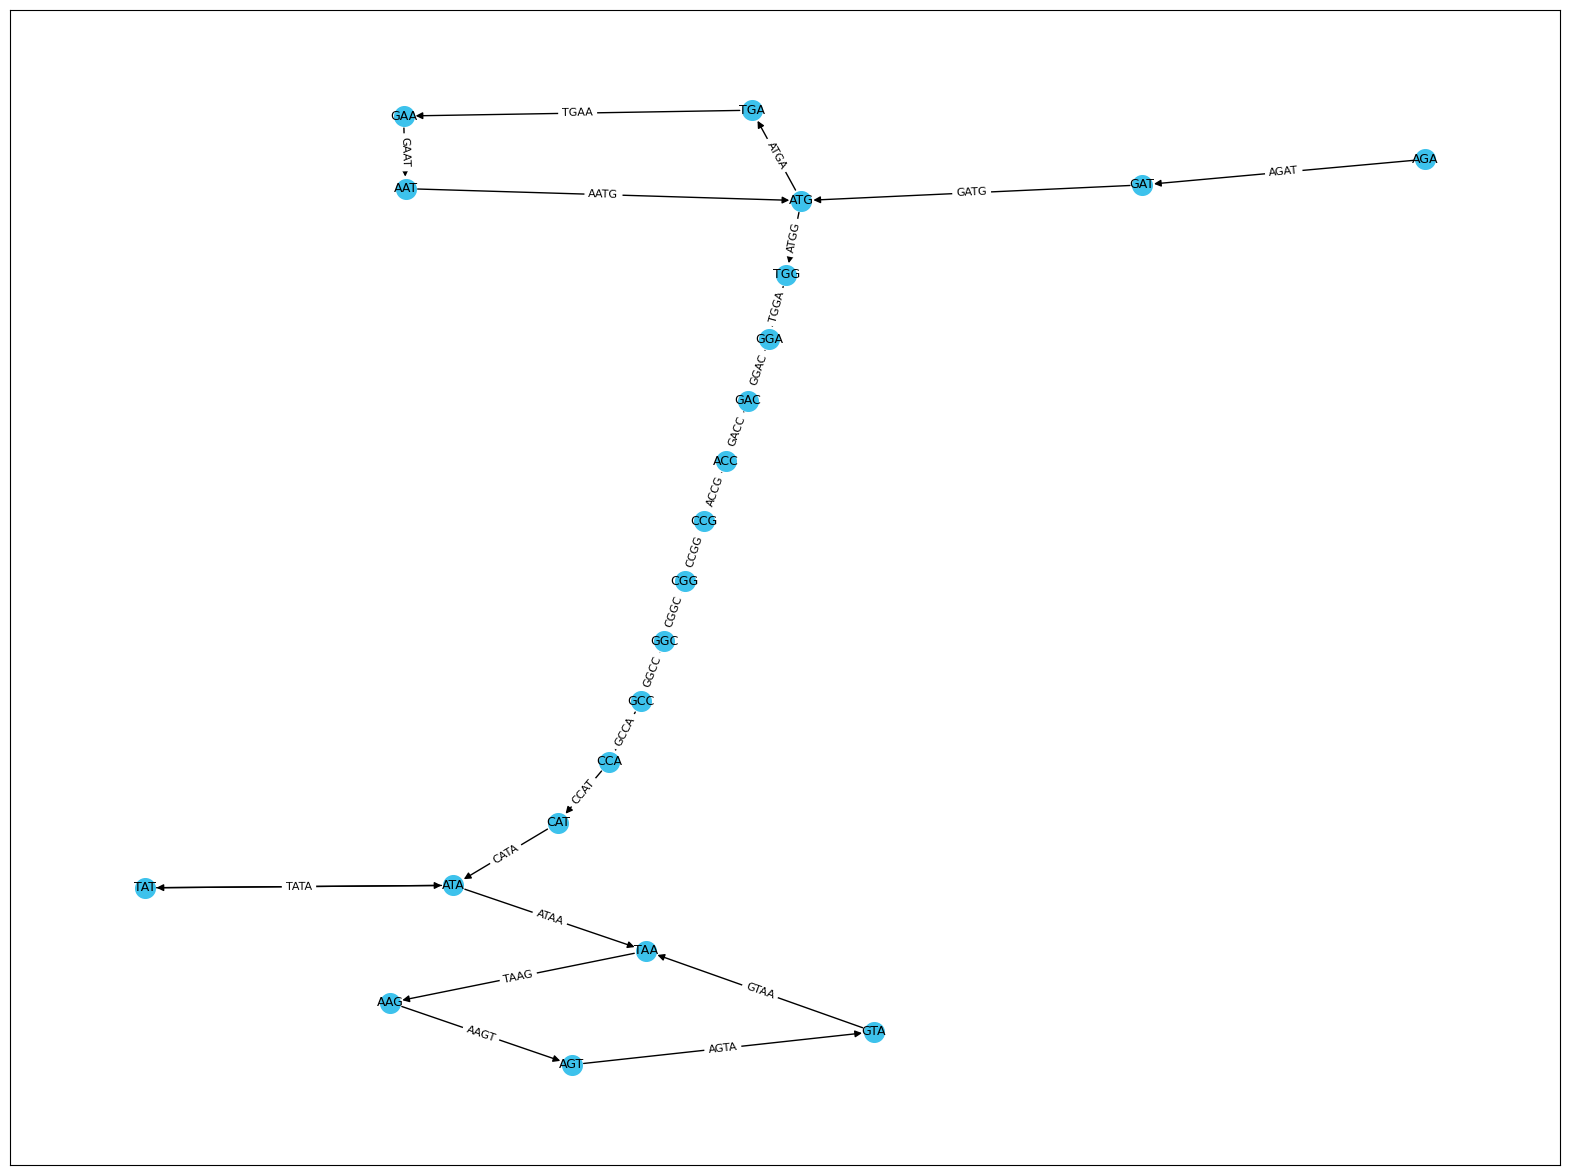

Граф после упрощений


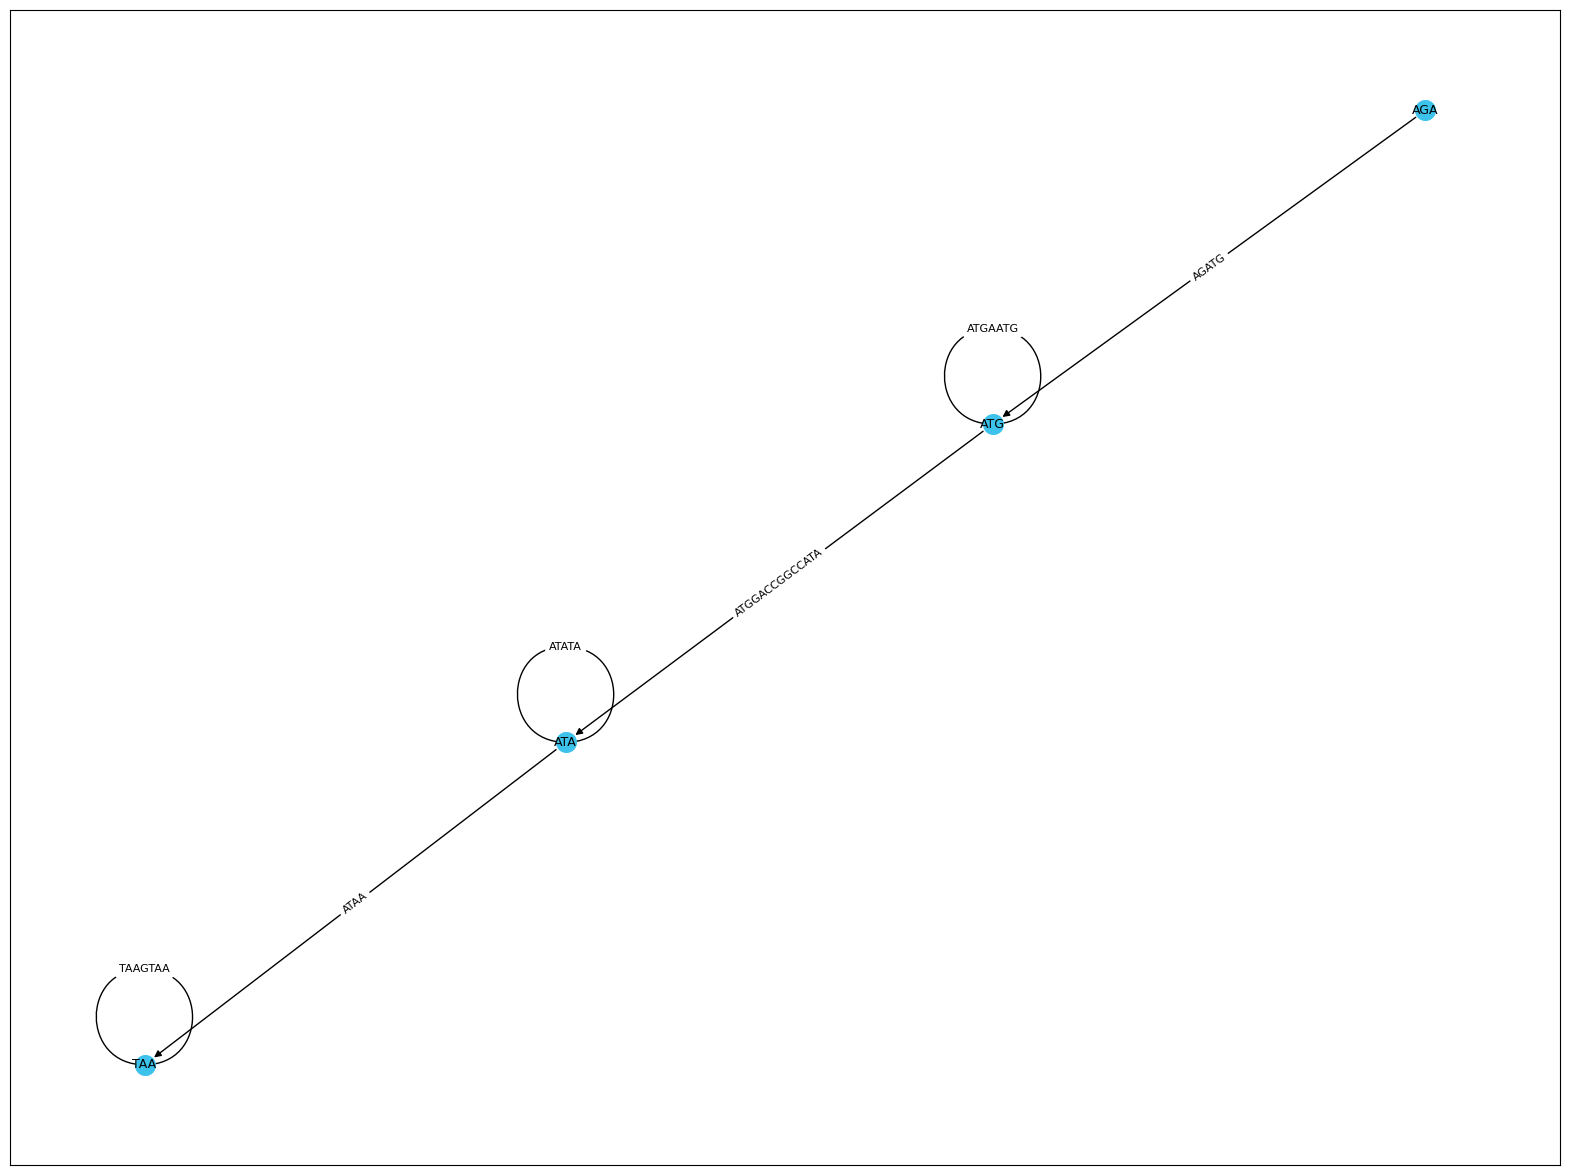

AGATGAATGGACCGGCCATATAAGTAAG
AGATGAATGGACCGGCCATATAAGTAAGTAA
Longest shared motif is:
AGATGAATGGACCGGCCATATAAGTAAG




In [191]:
test_sequence = ['AGATGAATGGACCGGCCATATAAGTAAG']


G = DBGraph(test_sequence, 4)
G.gen_kmers()
G.create_graph()
# interactive открывает интерактивную html-страницу графа. ВАЖНО! там не отображаются метки ребер и параллельные ребра
# layout регулирует то, как отображать граф на рисунке. Рекомендуется использовать nx.kamada_kawai_layout или nx.spectral_layout
G.visualize(interactive=False, show_edges=True, layout=nx.kamada_kawai_layout)
G.compact()
print('Граф после упрощений')
G.visualize(interactive=False, show_edges=True, layout=nx.kamada_kawai_layout)
# get_shared_motif печатает наидлиннейшую общую подстроку между собранной последовательностью и истинной
s1 = test_sequence[0]
s2 = G.assemble()
print(s1)
print(s2)
G.get_shared_motif(s1)


### Тест на удаление хвостов

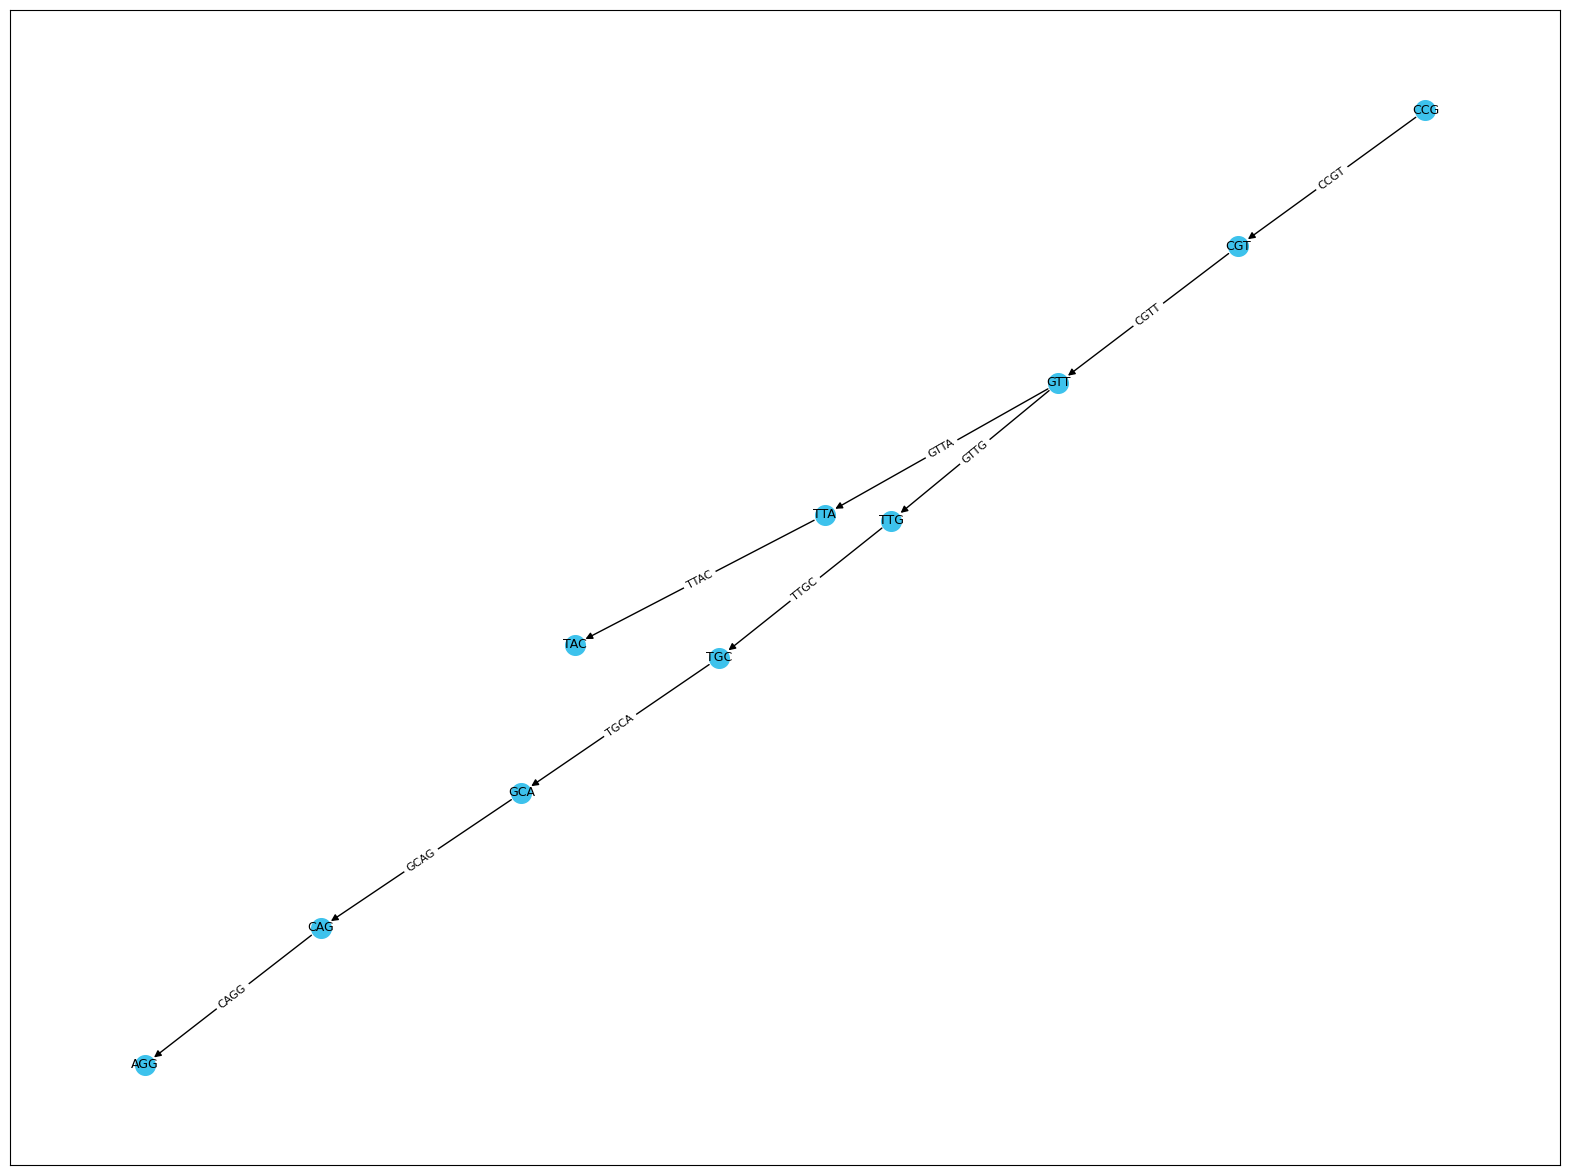

Граф после удаления хвостов


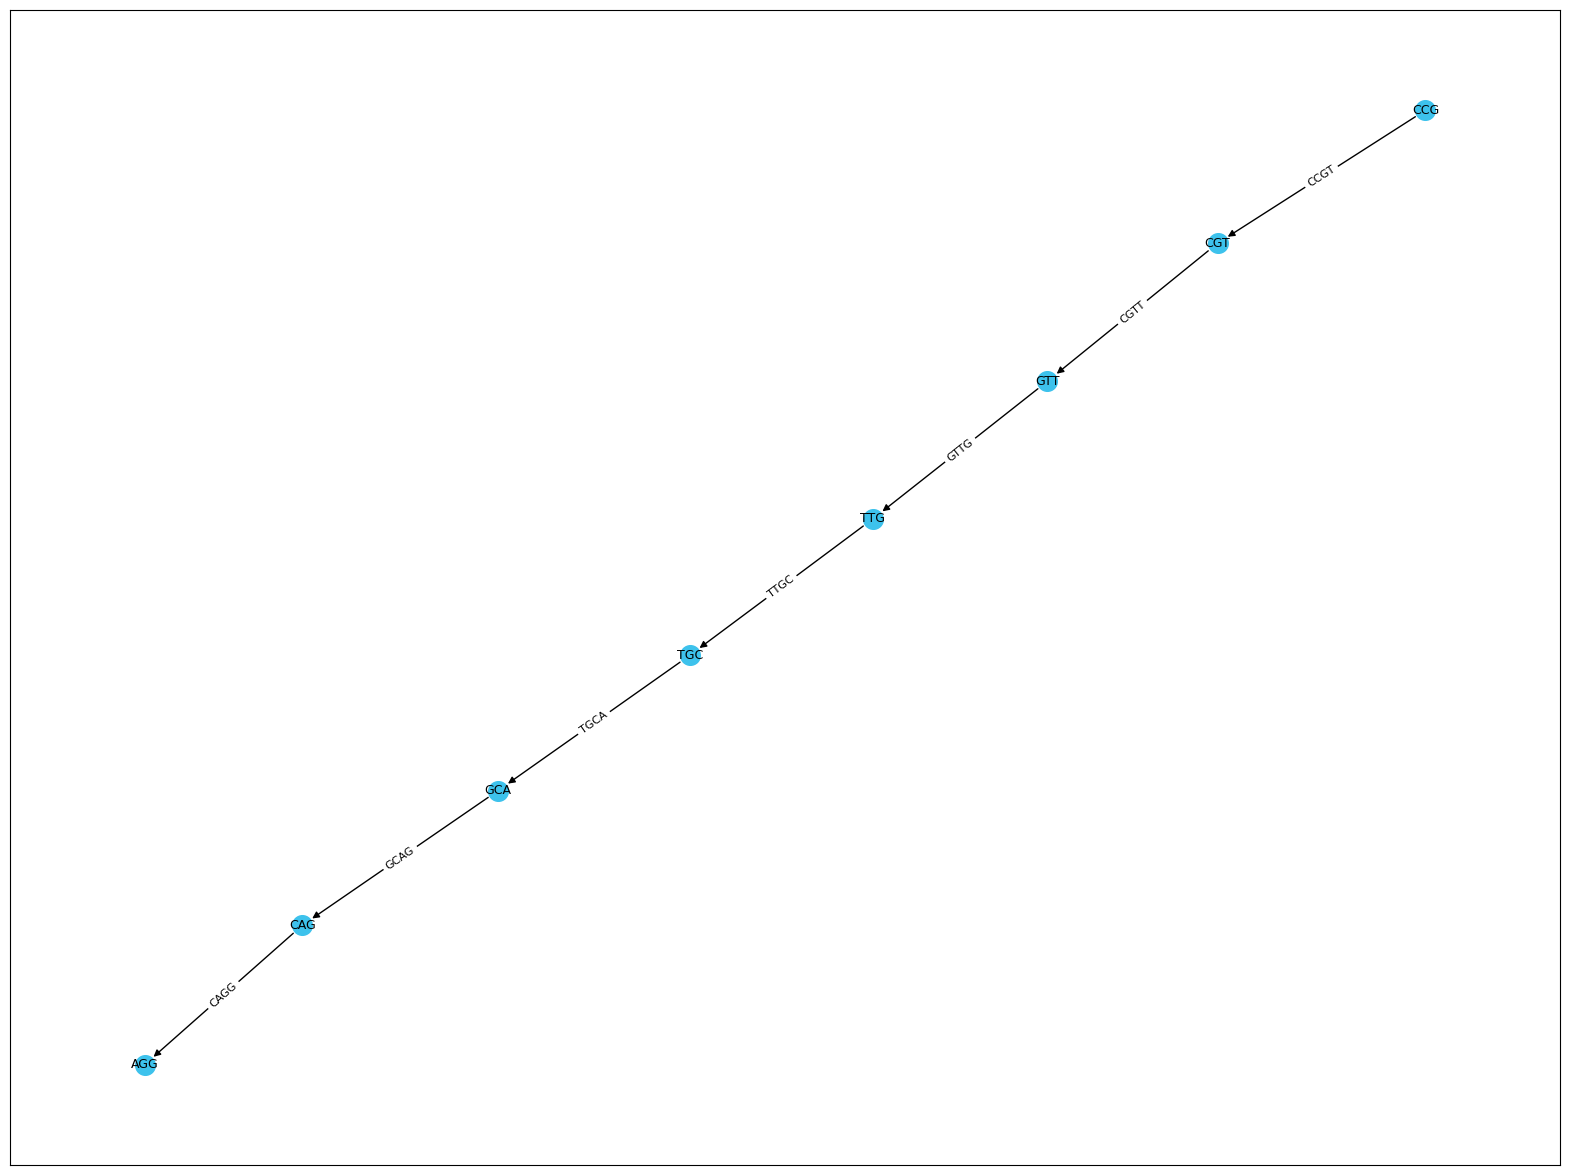

Граф после упрощений


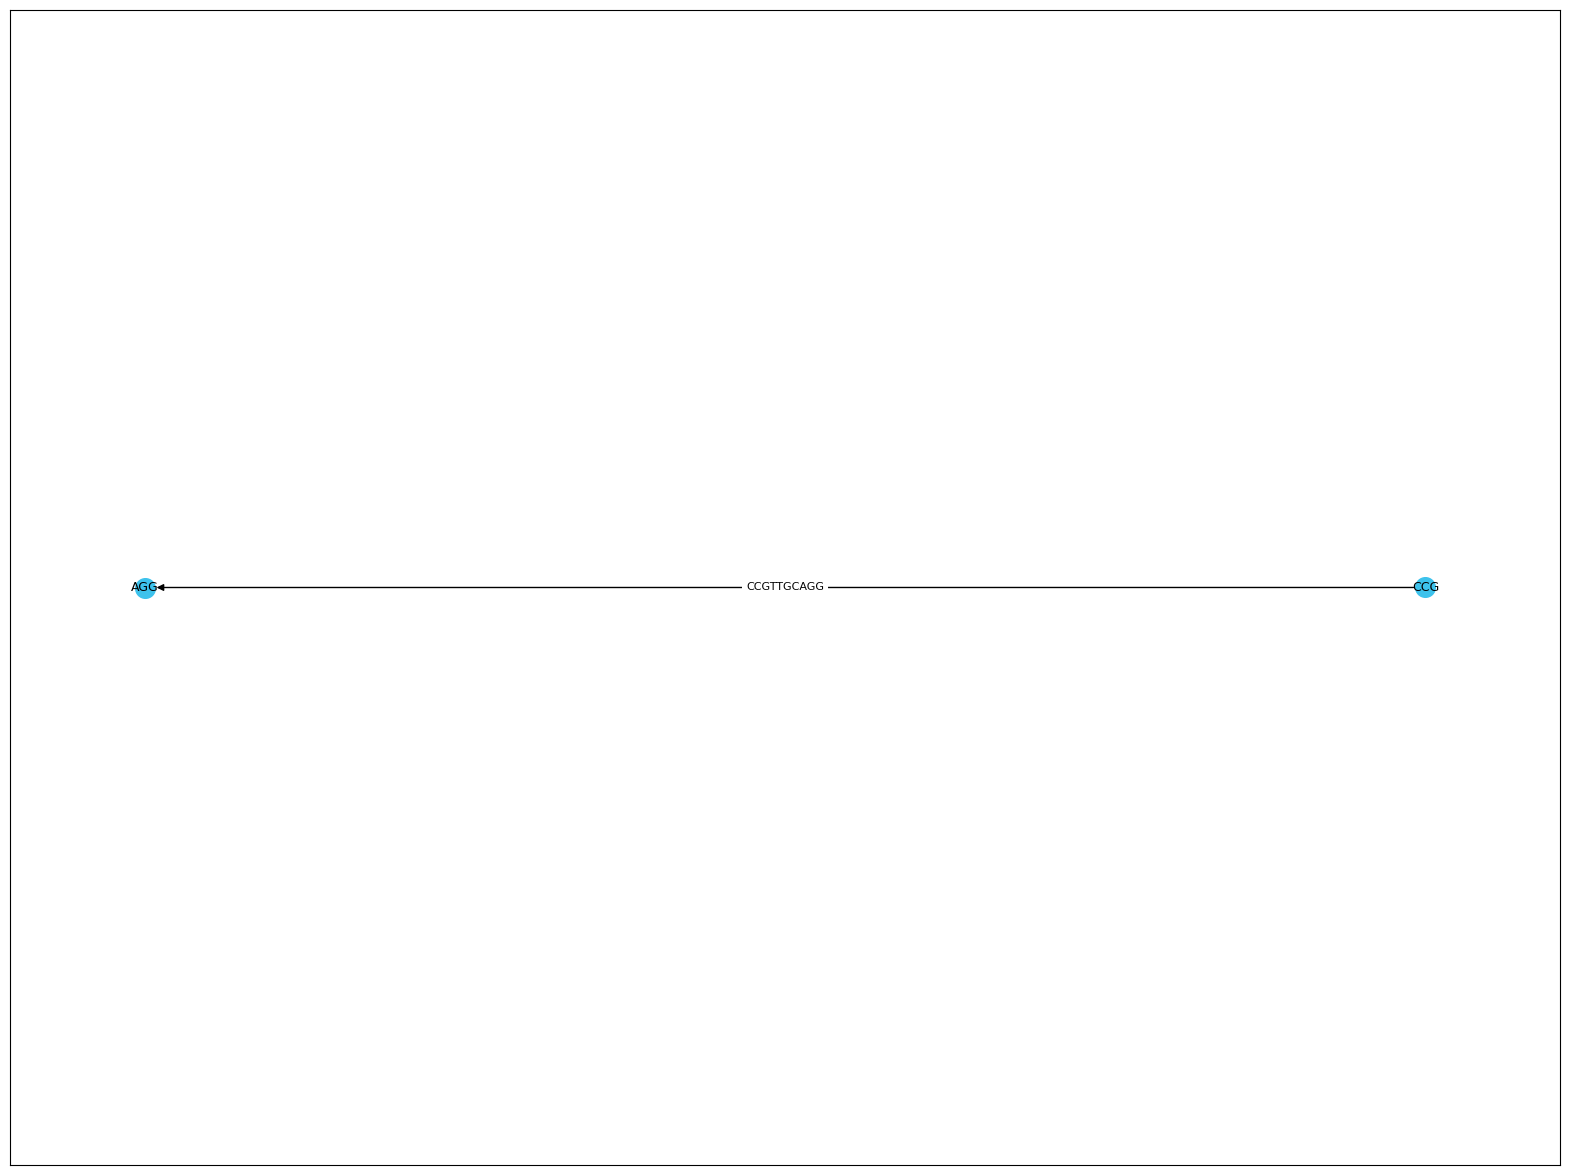

CCGTTGCAGG
CCGTTGCAGG
Longest shared motif is:
CCGTTGCAGG




In [192]:
test_sequences_tails = ['CCGTTG', 'CGTTAC', 'GTTGCA', 'TGCAGG']

G = DBGraph(test_sequences_tails, 4)
G.gen_kmers()
G.create_graph()
# interactive открывает интерактивную html-страницу графа. ВАЖНО! там не отображаются метки ребер и параллельные ребра
# layout регулирует то, как отображать граф на рисунке. Рекомендуется использовать nx.kamada_kawai_layout или nx.spectral_layout
G.visualize(interactive=False, show_edges=True, layout=nx.kamada_kawai_layout)
G.delete_tails()
print('Граф после удаления хвостов')
G.visualize(interactive=False, show_edges=True, layout=nx.kamada_kawai_layout)
G.compact()
print('Граф после упрощений')
G.visualize(interactive=False, show_edges=True, layout=nx.kamada_kawai_layout)
# get_shared_motif печатает наидлиннейшую общую подстроку между собранной последовательностью и истинной
s1 = 'CCGTTGCAGG'
s2 = G.assemble()
print(s1)
print(s2)
G.get_shared_motif(s1)


### Тест на удаление пузырей

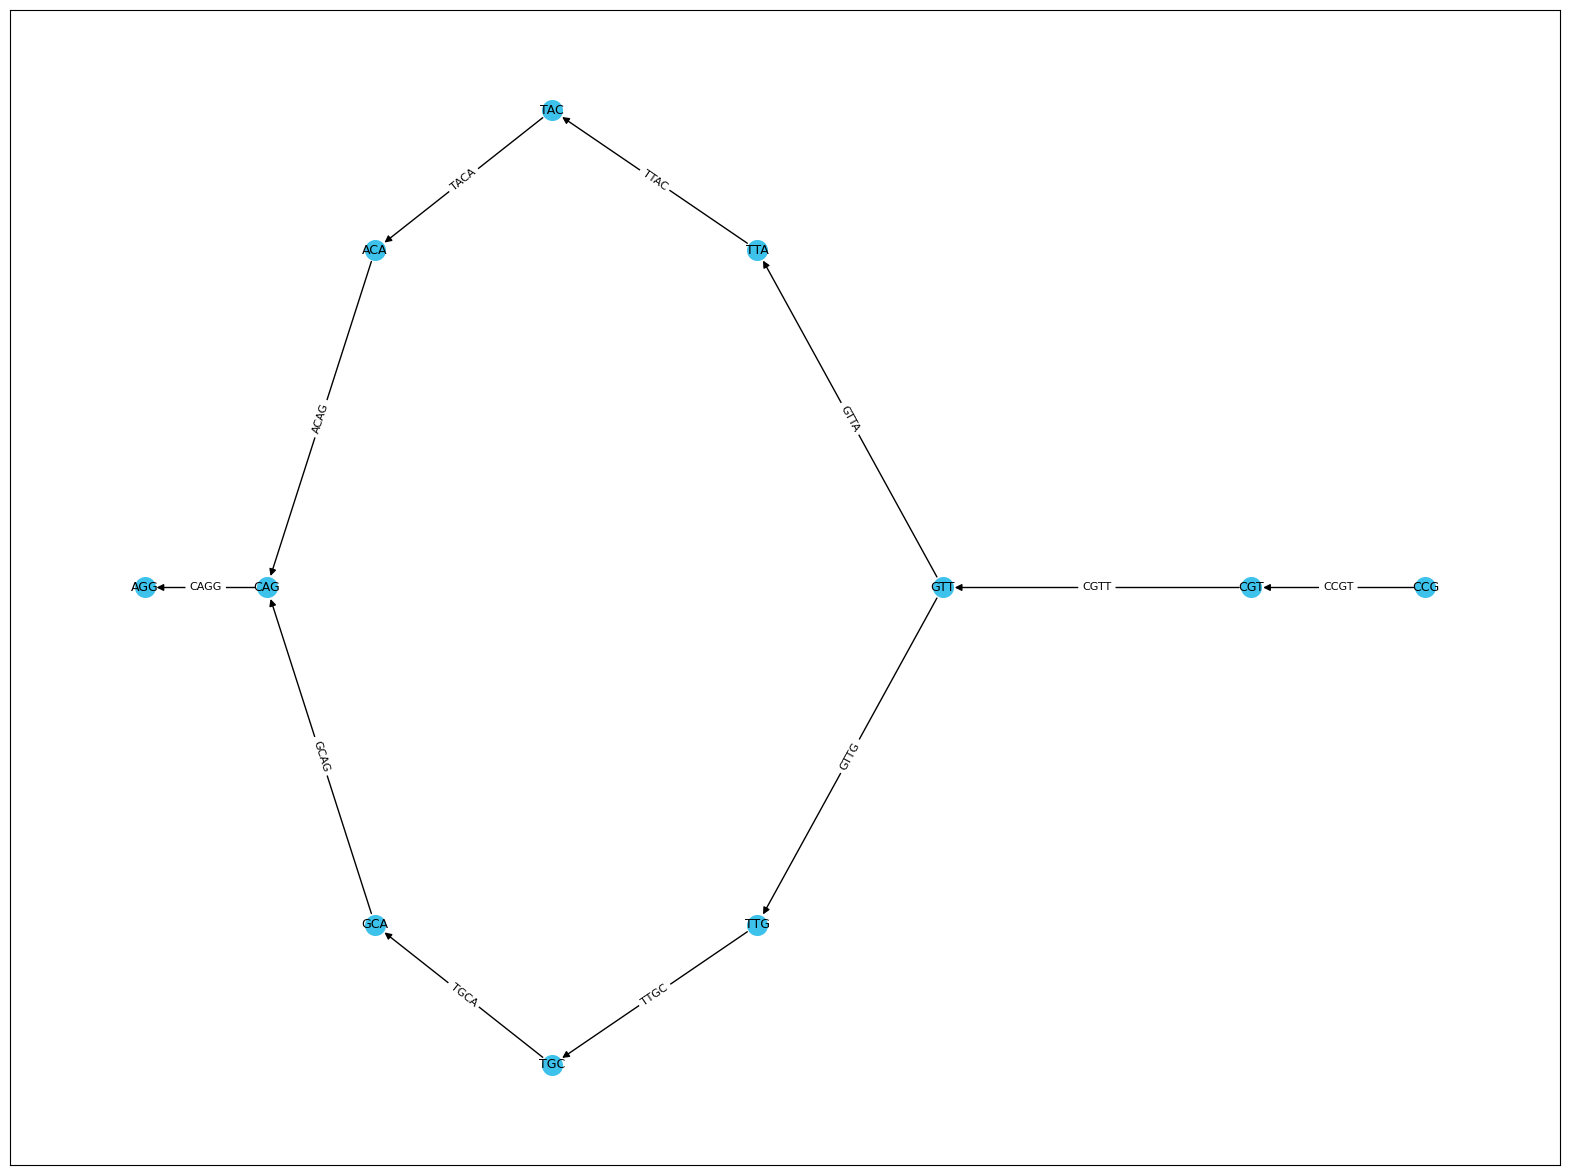

Граф после удаления пузырей


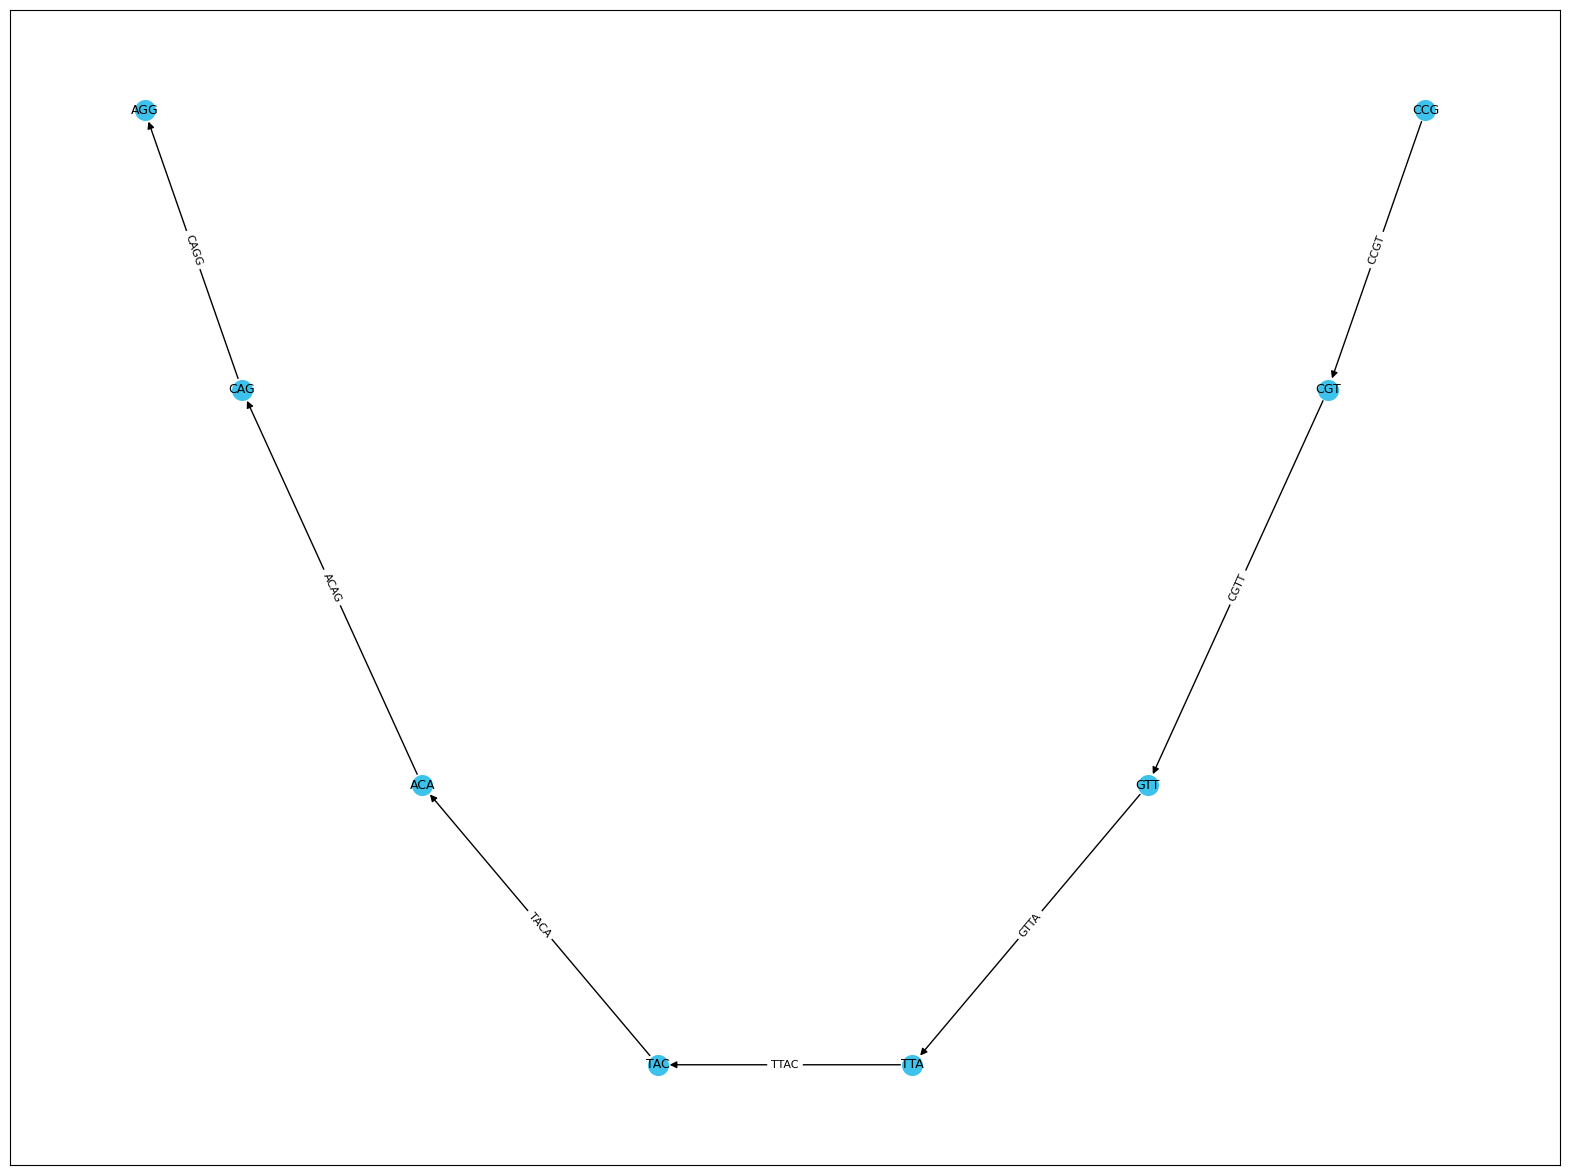

Граф после упрощений


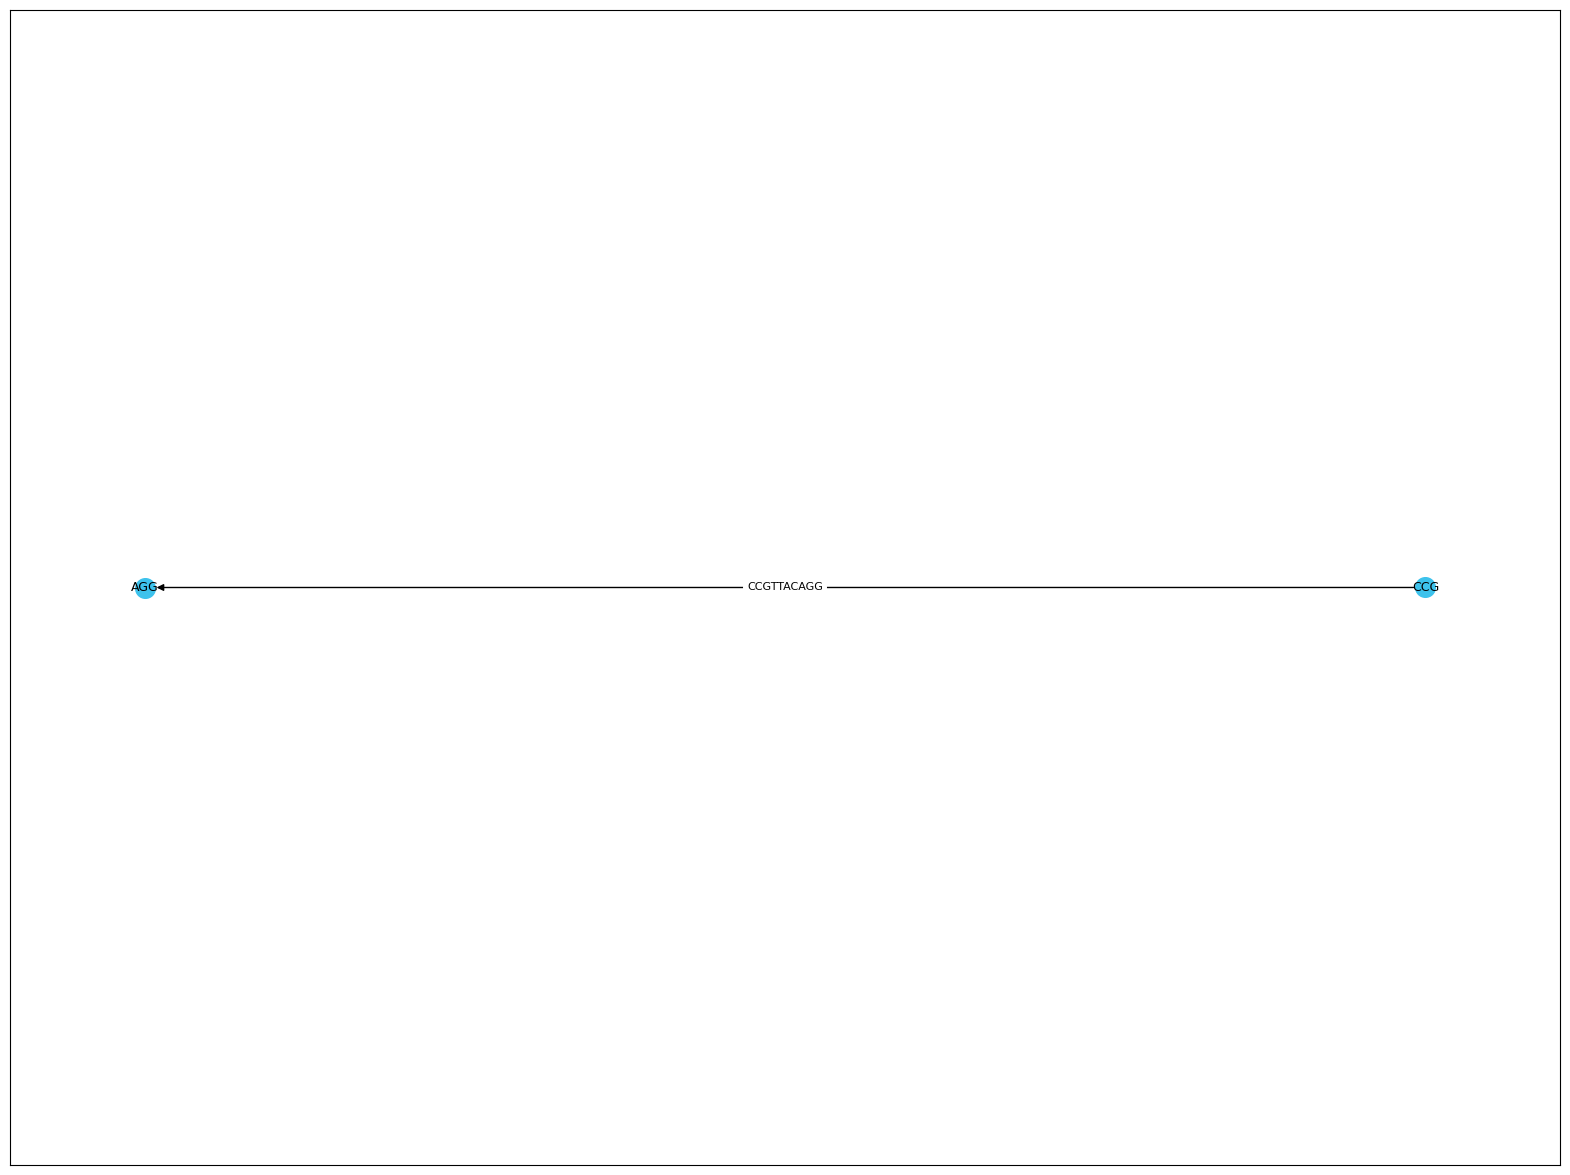

CCGTTGCAGG
CCGTTACAGG
Longest shared motif is:
CCGTT




In [193]:
test_sequences_bubble = ['CCGTTG', 'CGTTACAG', 'GTTGCA', 'TGCAGG']

G = DBGraph(test_sequences_bubble, 4)
G.gen_kmers()
G.create_graph()
# interactive открывает интерактивную html-страницу графа. ВАЖНО! там не отображаются метки ребер и параллельные ребра
# layout регулирует то, как отображать граф на рисунке. Рекомендуется использовать nx.kamada_kawai_layout или nx.spectral_layout
G.visualize(interactive=False, show_edges=True, layout=nx.spectral_layout)
G.delete_bubbles()
print('Граф после удаления пузырей')
G.visualize(interactive=False, show_edges=True, layout=nx.spectral_layout)
G.compact()
print('Граф после упрощений')
G.visualize(interactive=False, show_edges=True, layout=nx.kamada_kawai_layout)
# get_shared_motif печатает наидлиннейшую общую подстроку между собранной последовательностью и истинной
s1 = 'CCGTTGCAGG'
s2 = G.assemble()
print(s1)
print(s2)
G.get_shared_motif(s1)


### Применение графа Де Брюйна для работы с искусственно созданными ридами без ошибок

In [194]:
seq_name, seq_string = [], []
with open ("/home/pk/Desktop/BOTAY/BioinformaticsCourse2024PK/homework/2_2/reads.fasta",'r') as fa:
    for seq_record  in SeqIO.parse(fa,'fasta'):
        seq_name.append(str(seq_record.name))
        seq_string.append(str(seq_record.seq))

true_seq_name, true_seq_string = [], []
with open ("/home/pk/Desktop/BOTAY/BioinformaticsCourse2024PK/homework/2_2/sequense.fasta",'r') as fa:
    for seq_record  in SeqIO.parse(fa,'fasta'):
        true_seq_name.append(str(seq_record.name))
        true_seq_string.append(str(seq_record.seq))
true_seq = true_seq_string[0]

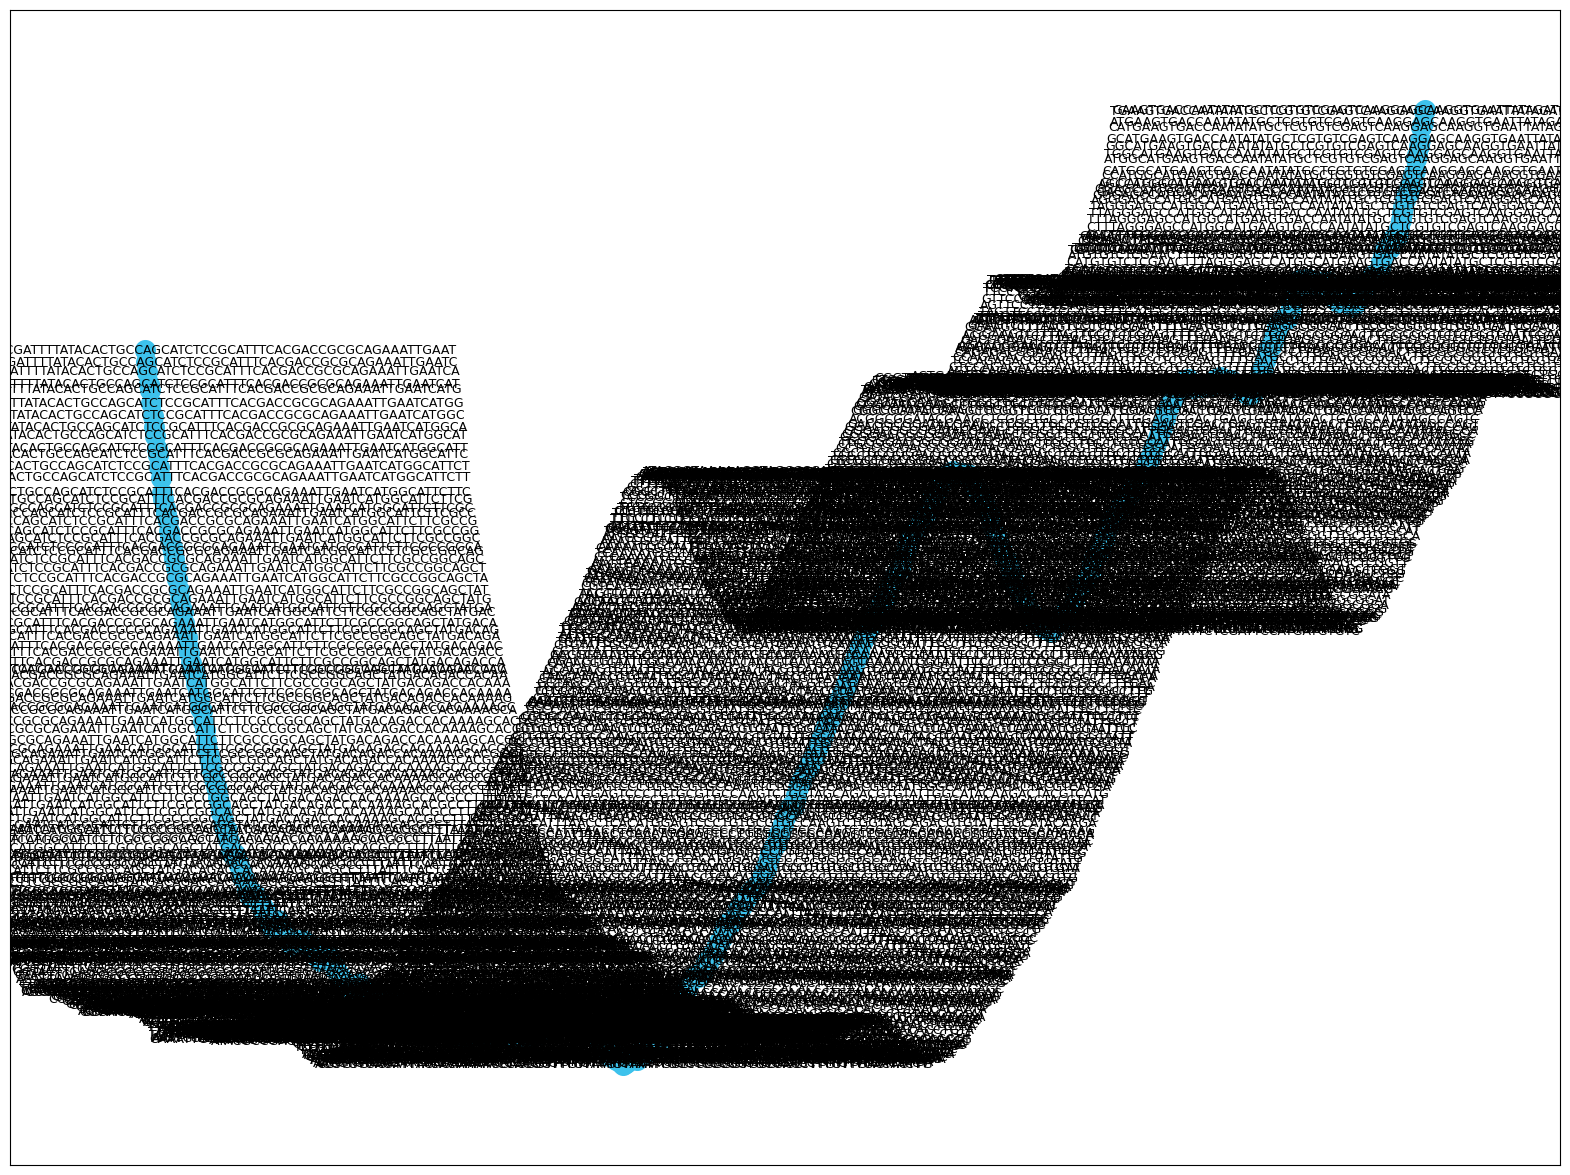

Number edges: 923
Number nodes: 924


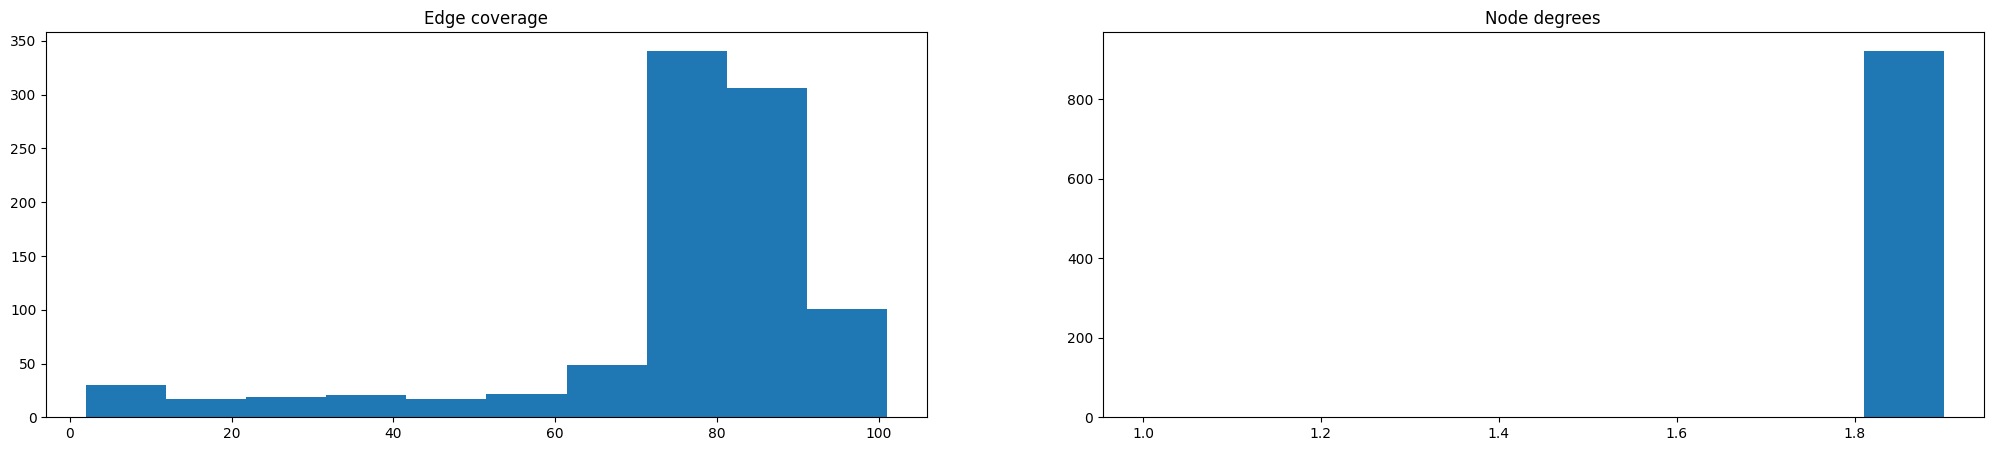

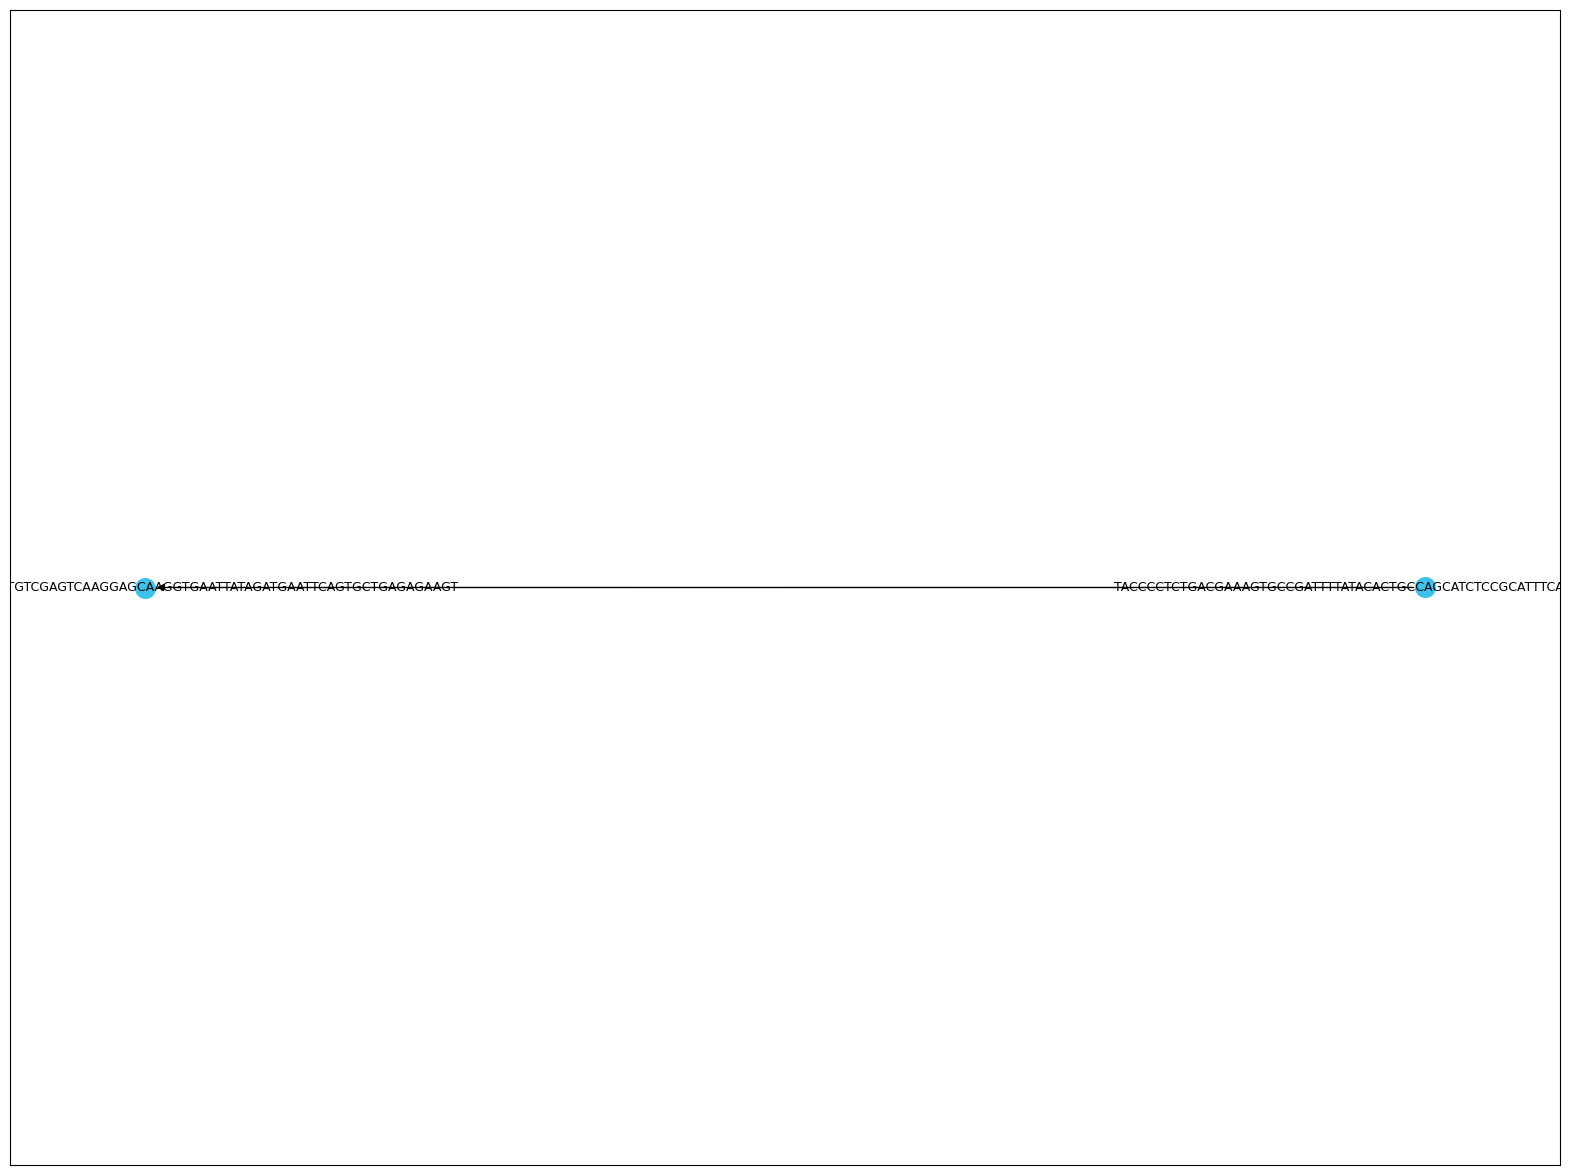

Number edges: 1
Number nodes: 2


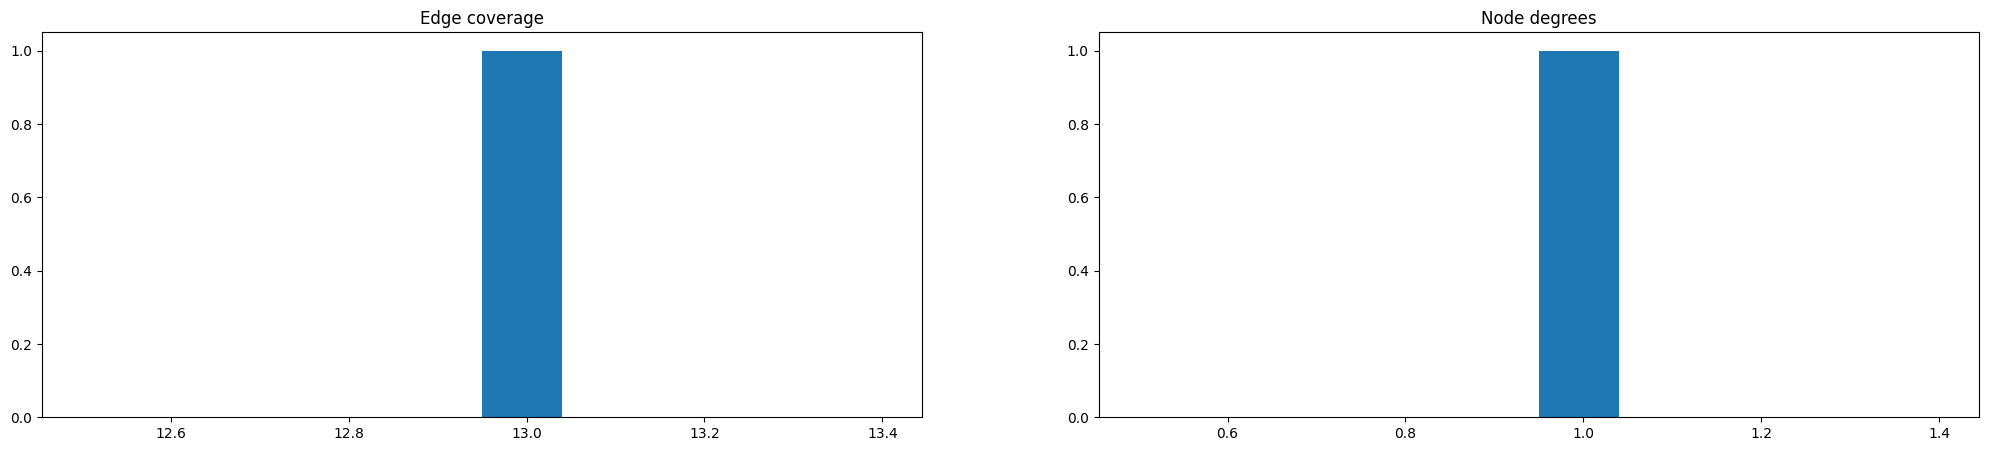

ACTACCCCTCTGACGAAAGTGCCGATTTTATACACTGCCAGCATCTCCGCATTTCACGACCGCGCAGAAATTGAATCATGGCATTCTTCGCCGGCAGCTATGACAGACCACAAAAGCACGCCTTTATTTCACTGATGAGATCGGTACTTCAGGCGCCCGTGGCGCCGGCATGCGTGTAGGCACGCAAGAGCGGCAAATGATGCGGCTAAACCAGGAACATGAACTCAGTTTCAAATTGTAATGTTCTAAACCTGTCTCAACTGAGCCGCTTTCGAATACGCCGAGCGGTTCCACAAGGCTTACAGCCTCTCGATTCCCTTTCCGGGACCTGCTCCTTTAGGATTACAACGTGTGAGATTTACACAAAATCCACGGTTTGTTATGTTAATTGCCTCCCGGTGCGACCTTTGTTTGACTACTTGAGCAGAGAACCCAACTCGCACACCTGTAACACAATAGGGAAGAGCGCCATTTAACCTCACATGGAGTCCCTGTGCGTGCCAAGTCTGGTAGCAGACGTGTATTGGCATACAAGACTACGTCATGAAAGTCAAAATCGGTATTTCCTTCTCCGGCTTTGACAATATACGGTAAAAACGTAGCCCCAGTACCCCAGTGGTCCAAGTTACAGACTGCGTAATAAGAATCTTTTCTGAGACCTCACGACCCATCCGTCCTTAACGAACGTGCGCCACGGACGTACTGTTATTCTCGATTCCATGATGTGTCGCTGCGGGACGGCGGATACGAAGCTCGGTTGCTGTCGCATTGGAGTCGACTGAGTGTAATAGACTGAGCAATATAGCCAGTCCAGAGACGGAAGTCTTTAGTTCCTCTCGAGTTTTGATGCTCTTGAGGCGGGACTTCCGCGGTCTCTGGTGATTCGACTAAGTCATGTGTCTCGAACTTTAGGGAGCCATGGCATGAAGTGACCAATATATGCTCGTGTCGAGTCAAGGAGCAAGGTGAATTATAGATGAATTCAGTGCTGAGAGAAGTA

In [195]:
G = DBGraph(seq_string, 75)
G.gen_kmers()
G.create_graph()
G.visualize(interactive=False, show_edges=False, layout=nx.kamada_kawai_layout)
G.get_statistics()
G.compact()
G.visualize(interactive=False, show_edges=False, layout=nx.kamada_kawai_layout)
G.get_statistics()
# get_shared_motif печатает наидлиннейшую общую подстроку между собранной последовательностью и истинной
s1 = true_seq
s2 = G.assemble()
print(s1)
print(s2)
G.get_shared_motif(s1)


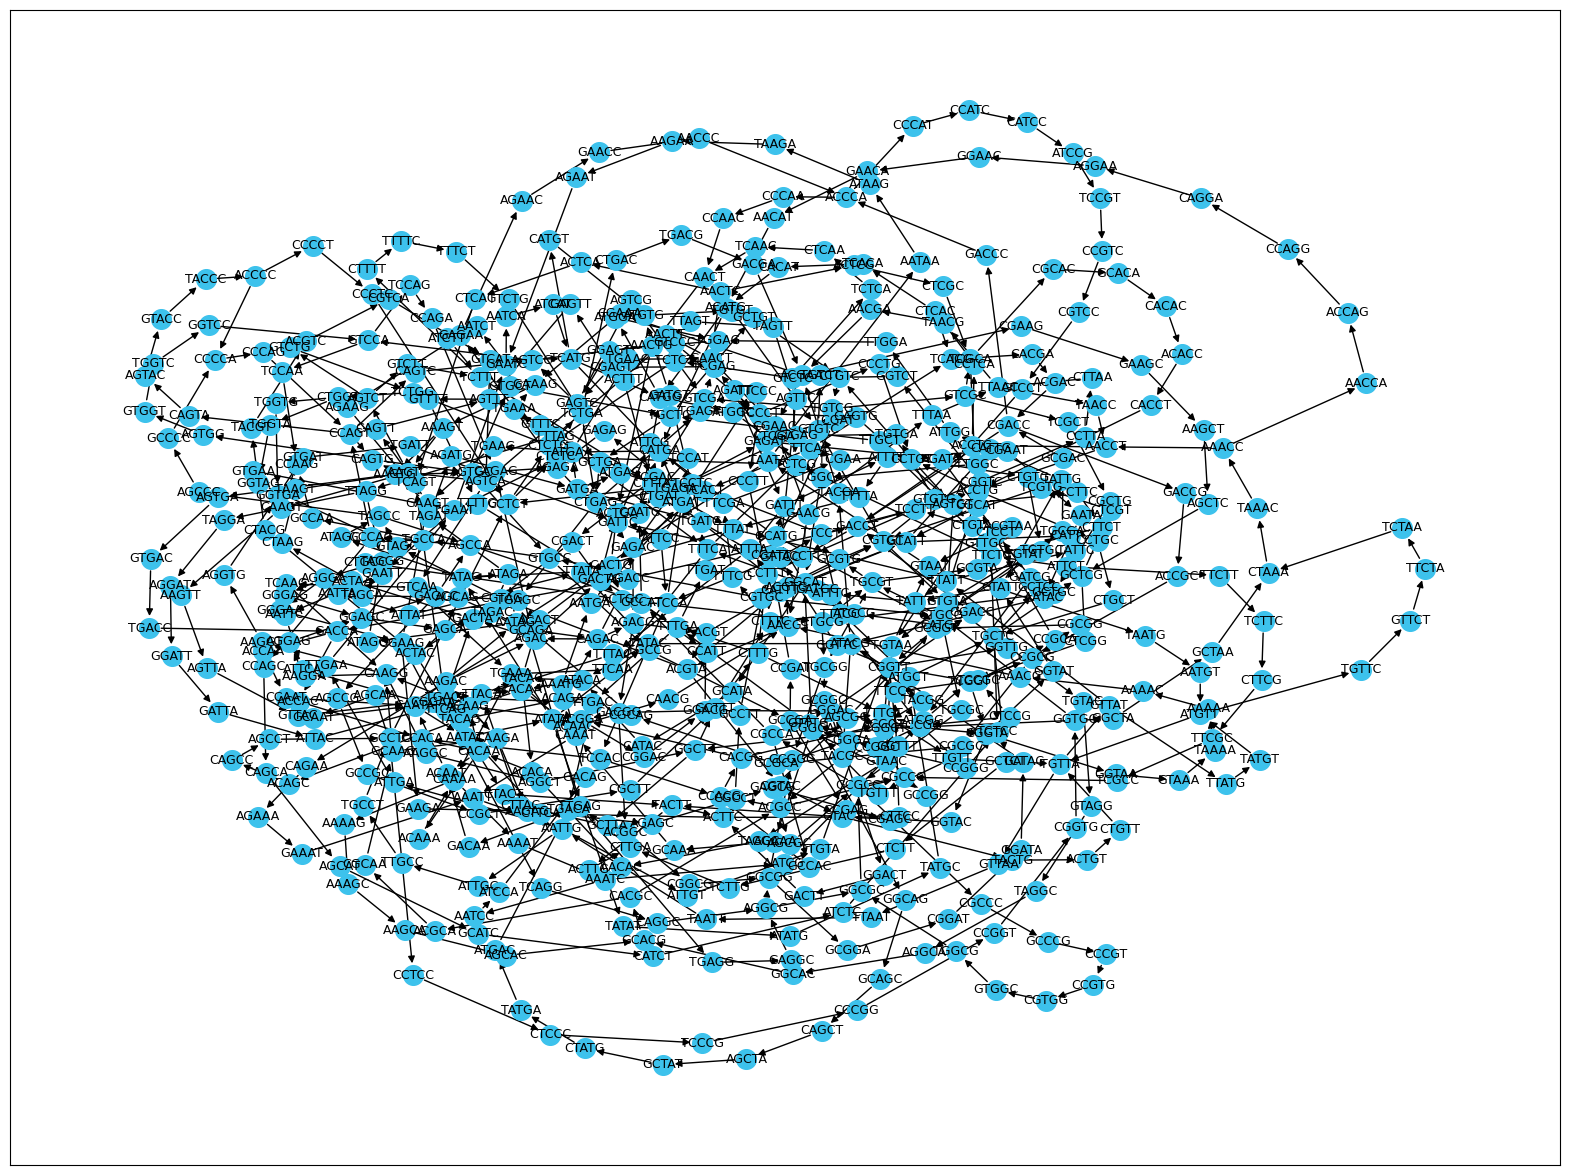

Number edges: 883
Number nodes: 637


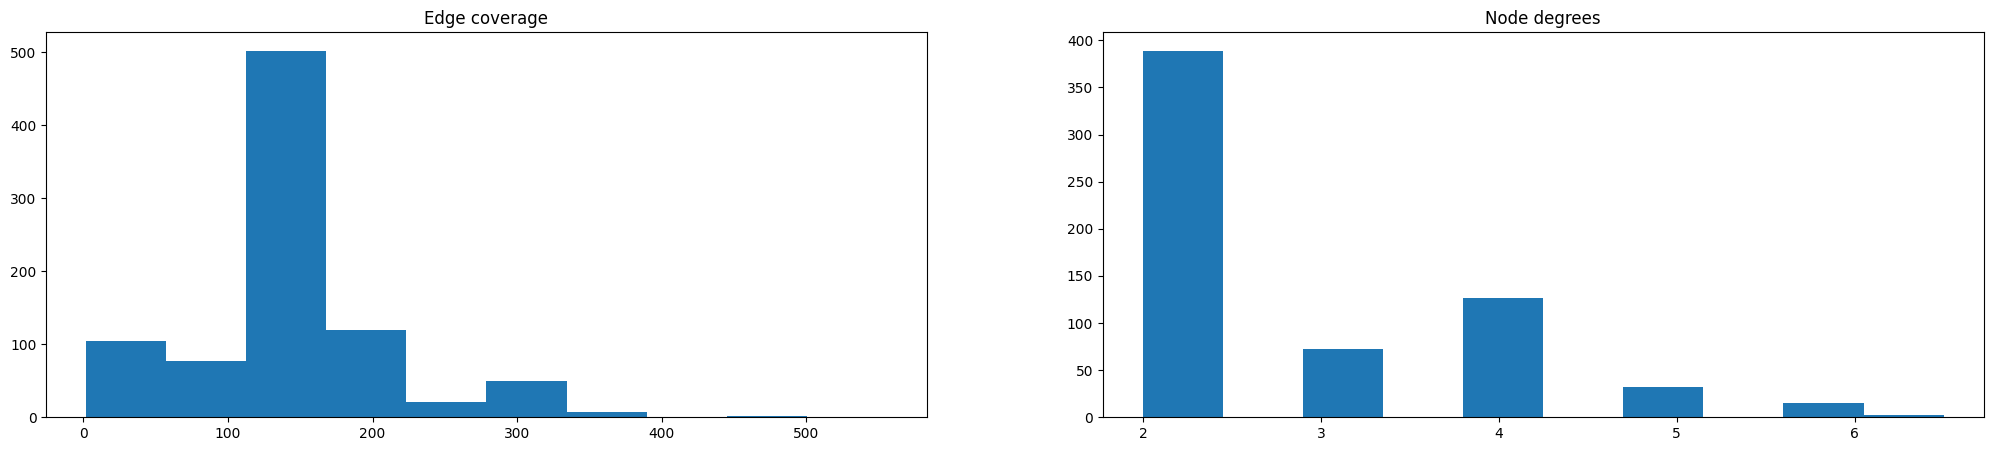

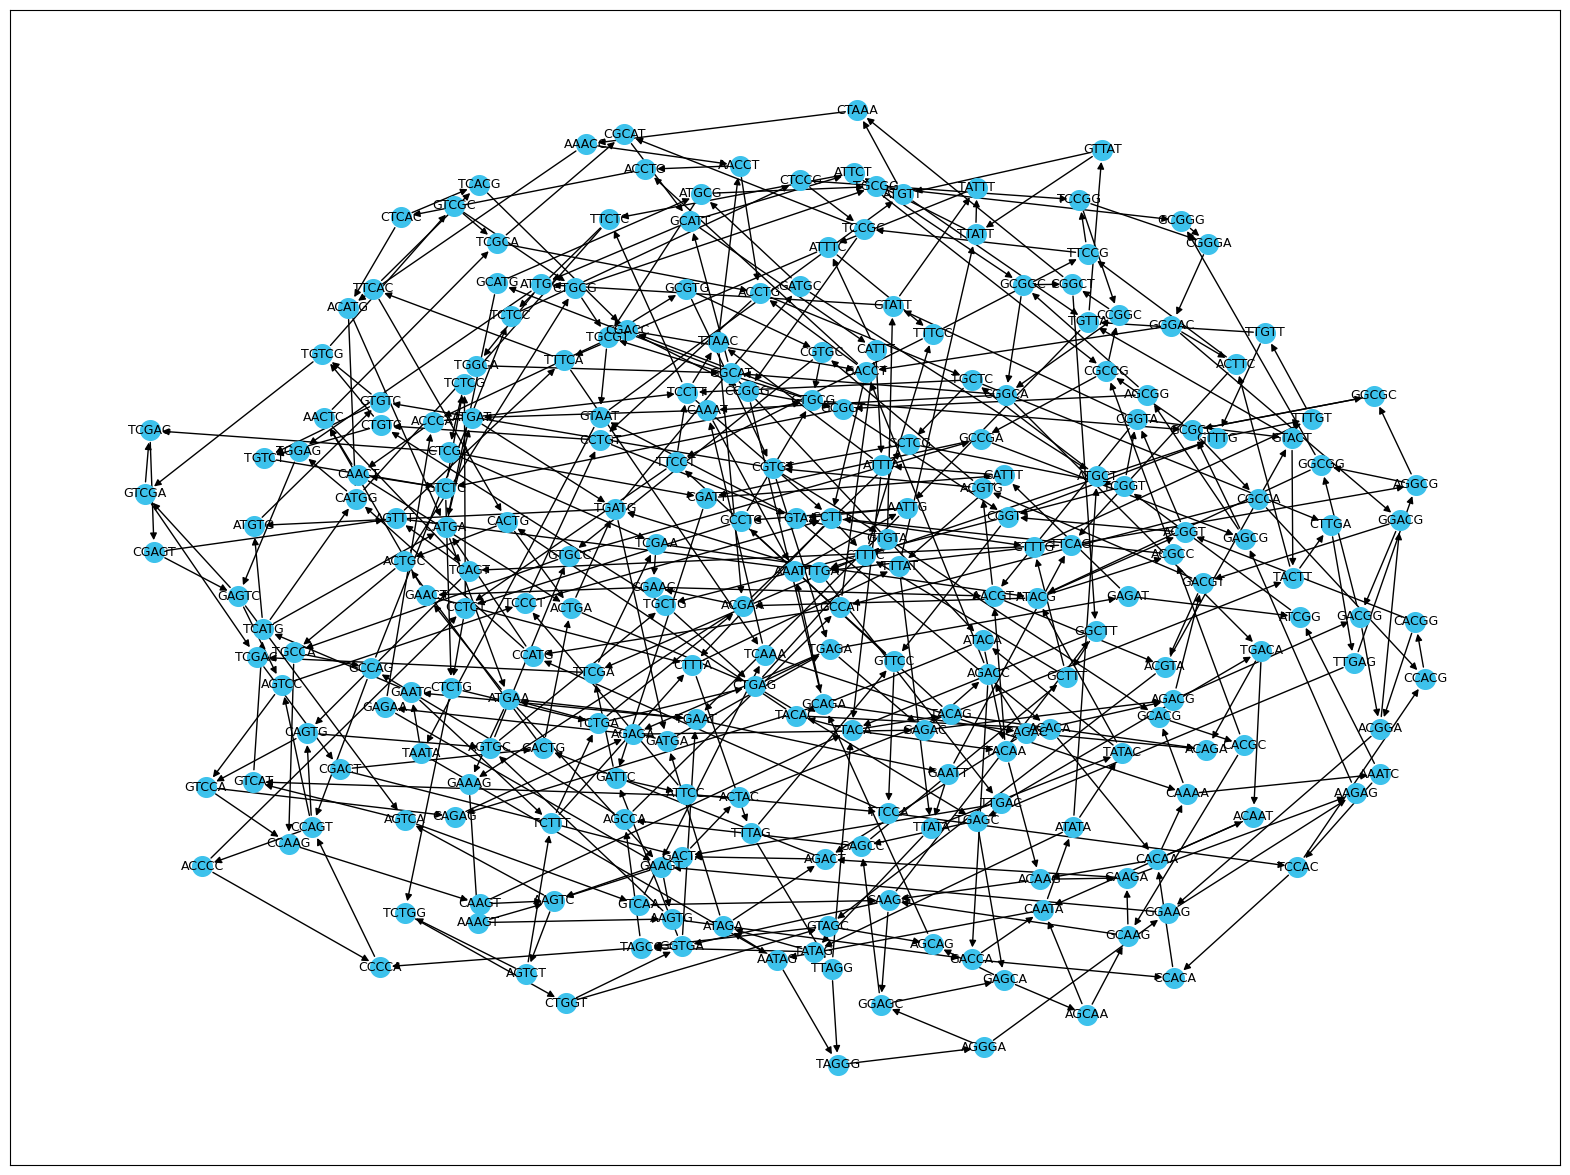

Number edges: 494
Number nodes: 248


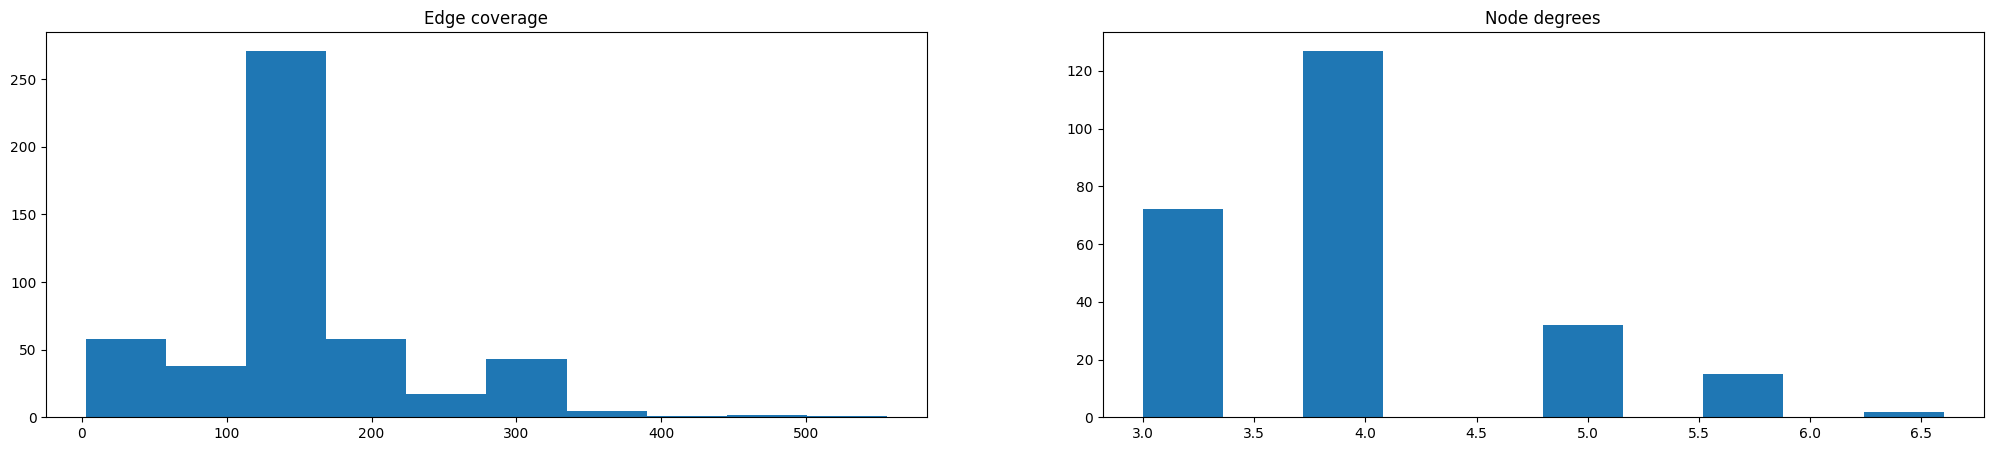

ACTACCCCTCTGACGAAAGTGCCGATTTTATACACTGCCAGCATCTCCGCATTTCACGACCGCGCAGAAATTGAATCATGGCATTCTTCGCCGGCAGCTATGACAGACCACAAAAGCACGCCTTTATTTCACTGATGAGATCGGTACTTCAGGCGCCCGTGGCGCCGGCATGCGTGTAGGCACGCAAGAGCGGCAAATGATGCGGCTAAACCAGGAACATGAACTCAGTTTCAAATTGTAATGTTCTAAACCTGTCTCAACTGAGCCGCTTTCGAATACGCCGAGCGGTTCCACAAGGCTTACAGCCTCTCGATTCCCTTTCCGGGACCTGCTCCTTTAGGATTACAACGTGTGAGATTTACACAAAATCCACGGTTTGTTATGTTAATTGCCTCCCGGTGCGACCTTTGTTTGACTACTTGAGCAGAGAACCCAACTCGCACACCTGTAACACAATAGGGAAGAGCGCCATTTAACCTCACATGGAGTCCCTGTGCGTGCCAAGTCTGGTAGCAGACGTGTATTGGCATACAAGACTACGTCATGAAAGTCAAAATCGGTATTTCCTTCTCCGGCTTTGACAATATACGGTAAAAACGTAGCCCCAGTACCCCAGTGGTCCAAGTTACAGACTGCGTAATAAGAATCTTTTCTGAGACCTCACGACCCATCCGTCCTTAACGAACGTGCGCCACGGACGTACTGTTATTCTCGATTCCATGATGTGTCGCTGCGGGACGGCGGATACGAAGCTCGGTTGCTGTCGCATTGGAGTCGACTGAGTGTAATAGACTGAGCAATATAGCCAGTCCAGAGACGGAAGTCTTTAGTTCCTCTCGAGTTTTGATGCTCTTGAGGCGGGACTTCCGCGGTCTCTGGTGATTCGACTAAGTCATGTGTCTCGAACTTTAGGGAGCCATGGCATGAAGTGACCAATATATGCTCGTGTCGAGTCAAGGAGCAAGGTGAATTATAGATGAATTCAGTGCTGAGAGAAGTA

In [196]:
G = DBGraph(seq_string, 6)
G.gen_kmers()
G.create_graph()
G.visualize(interactive=False, show_edges=False, layout=nx.kamada_kawai_layout)
G.get_statistics()
G.compact()
G.visualize(interactive=False, show_edges=False, layout=nx.kamada_kawai_layout)
G.get_statistics()
# get_shared_motif печатает наидлиннейшую общую подстроку между собранной последовательностью и истинной
s1 = true_seq
s2 = G.assemble()
print(s1)
print(s2)
G.get_shared_motif(s1)


### Работа с реальными ридами

In [8]:
!trimmomatic SE ERR008613.fastq.gz ERR008613_trimm.fastq.gz ILLUMINACLIP:TruSeq3-SE.fa:2:30:10 LEADING:3 TRAILING:3 SLIDINGWINDOW:4:15 MINLEN:36 -phred33

TrimmomaticSE: Started with arguments:
 ERR008613.fastq.gz ERR008613_trimm.fastq.gz ILLUMINACLIP:TruSeq3-SE.fa:2:30:10 LEADING:3 TRAILING:3 SLIDINGWINDOW:4:15 MINLEN:36 -phred33
Automatically using 4 threads
Using Long Clipping Sequence: 'AGATCGGAAGAGCGTCGTGTAGGGAAAGAGTGTA'
Using Long Clipping Sequence: 'AGATCGGAAGAGCACACGTCTGAACTCCAGTCAC'
ILLUMINACLIP: Using 0 prefix pairs, 2 forward/reverse sequences, 0 forward only sequences, 0 reverse only sequences
Input Reads: 28428648 Surviving: 28404998 (99.92%) Dropped: 23650 (0.08%)
TrimmomaticSE: Completed successfully


In [3]:
from Bio import SeqIO
import gzip

seq_name, seq_string = [], []
with gzip.open("ERR008613_trimm.fastq.gz", "rt") as handle:
    for seq_record in SeqIO.parse(handle, "fastq"):
        seq_string.append(str(seq_record.seq))

In [4]:
len(seq_string)

28404998

In [5]:
G = DBGraph(seq_string, 50)
G.gen_kmers()

: 

In [ ]:
print(len(G.kmers))

28352196


In [20]:
G.create_graph()

: 

In [ ]:
seq = G.assemble()